<a href="https://colab.research.google.com/github/vishnu-rai/Weak-Galerkin-Solver/blob/main/WGSolver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git init

Initialized empty Git repository in /content/.git/


In [ ]:
!git config --global user.email "vishnurai1999@gmail.com"

In [ ]:
!git config --global user.name "vishnu-rai"

In [ ]:
!git add .

In [ ]:
!git commit -m "Solving for diamond element"

[master (root-commit) 5c27ee1] Solving for diamond element
 20 files changed, 50872 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_config
 create mode 100644 .config/config_sentinel
 create mode 100644 .config/configurations/config_default
 create mode 100644 .config/gce
 create mode 100644 .config/logs/2023.04.27/13.34.04.553193.log
 create mode 100644 .config/logs/2023.04.27/13.34.30.224760.log
 create mode 100644 .config/logs/2023.04.27/13.34.57.714416.log
 create mode 100644 .config/logs/2023.04.27/13.35.06.138145.log
 create mode 100644 .config/logs/2023.04.27/13.35.34.172195.log
 create mode 100644 .config/logs/2023.04.27/13.35.35.098957.log
 create mode 100644 diamond_mesh.png
 create mode 100755 sample_data/README.md
 create mode 100755 sample_data/anscombe.json
 create mode 100644 sample_data/california_housing_test.csv

In [ ]:
!git checkout master

Already on 'master'


In [ ]:
!git remote set-url origin https://github.com/vishnu-rai/Weak-Galerkin-Solver

In [ ]:
!git push origin master

fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sympy as sp
from sympy import symbols, eye, zeros, integrate
from typing import Tuple
from scipy.sparse import dok_matrix, csc_matrix,csr_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sympy import symbols, eye, zeros, integrate

In [ ]:
def findCoords(n):
  square_coords = []
  diamond_coords=[]

  for x in range(n):
      for y in range(n):
          square_coord = [(x/n, y/n), ((x+1)/n, y/n), ((x+1)/n, (y+1)/n), (x/n, (y+1)/n), (x/n, y/n)]
          square_coords.append(square_coord)
          diamond_coord = [((x+0.5)/n, (y+1)/n), ((x+1)/n, (y+0.5)/n), ((x+0.5)/n, y/n), (x/n, (y + 0.5)/n), ((x + 0.5)/n, (y + 1)/n)]
          diamond_coords.append(diamond_coord)

  return square_coords,diamond_coords

In [ ]:
def findVertices(vertice,n):
  vertices={}
  verticesToCoord={}
  vertices[(0,0)]=vertice
  verticesToCoord[vertice]=(0,0)
  vertice+=1
  for i in range(0,(2*n)+1):
    for j in range(0,(i%2)+n):
      x=j/n
      y=i/(2*n)
      if i%2==0:
        x=x+1/(2*n)
      vertices[(x,y)]=vertice
      verticesToCoord[vertice]=(x,y)
      vertice+=1
    if i==0:
      vertices[(1,0)]=vertice
      verticesToCoord[vertice]=(1,0)
      vertice+=1
    if i==2*n-1:
      vertices[(0,1)]=vertice
      verticesToCoord[vertice]=(0,1)
      vertice+=1
  vertices[(1,1)]=vertice
  verticesToCoord[vertice]=(1,1)
  vertice+=1
  return vertices,verticesToCoord

In [ ]:
def findDiamondVertices(n):
  diamond_vertices=[]
  for i in range(0,2*n-1):
    for j in range(0,n-(i%2)): 
      temp = n+3+(n+1)*(math.ceil(i/2))+(n)*(i//2)+j
      if i!=0:
        diamond = [temp,temp+n+1,temp+1,temp-n]
      else:
        diamond = [temp,temp+n+1,temp+1,temp-n-1]

      if i==2*n-2:
        diamond = [temp,temp+n+2,temp+1,temp-n]

      diamond_vertices.append(diamond) 
  
  return diamond_vertices

In [ ]:
def findTriangleVertices(y,n,vertices):
  triangle_vertices=[]
  triangle_vertices.append([vertices[(0,0)],vertices[(0,1/(2*n))],vertices[(1/(2*n),0)],0])
  while y<1-(1/(2*n)):
    triangle_vertices.append([vertices[(0,y)],vertices[(0,y+(1/n))],vertices[((1/(2*n)),y+(1/(2*n)))],0])
    y=y+(1/n)
  triangle_vertices.append([vertices[(0,1-(1/(2*n)))],vertices[(0,1)],vertices[(1/(2*n),1)],0])
  x=1/(2*n)
  while x<1-(1/(2*n)):
    triangle_vertices.append([vertices[(x,1)],vertices[(x+(1/n),1)],vertices[(x+1/(2*n),1-1/(2*n))],0])
    x=x+(1/n)
  triangle_vertices.append([vertices[(1-1/(2*n),1)],vertices[(1,1)],vertices[(1,1-1/(2*n))],0])
  y=1-(1/(2*n))
  while y>1/(2*n):
    triangle_vertices.append([vertices[(1,y)],vertices[(1,y-(1/n))],vertices[(1-(1/(2*n)),y-(1/(2*n)))],0])
    y=y-(1/n)
  triangle_vertices.append([vertices[(1-(1/(2*n)),0)],vertices[(1,1/(2*n))],vertices[(1,0)],0])
  x=1-(1/(2*n))
  while x>1/(2*n):
    triangle_vertices.append([vertices[(x,0)],vertices[(x-(1/n),0)],vertices[(x-(1/(2*n)),(1/(2*n)))],0])
    x=x-(1/n)
  return triangle_vertices

In [ ]:
def findEdges(edge,n,vertices):
  q=1/(2*n)
  h=1/n
  edges={}
  temp_edges={}
  edges[vertices[(0,0)],vertices[q,0]]=edge
  edges[vertices[q,0],vertices[(0,0)]]=edge
  temp_edges[vertices[(0,0)],vertices[q,0]]=edge
  edge=edge+1
  x=q
  while x<1-h:
    edges[vertices[(x,0)],vertices[x+h,0]]=edge
    edges[vertices[x+h,0],vertices[(x,0)]]=edge
    temp_edges[vertices[(x,0)],vertices[x+h,0]]=edge
    edge=edge+1
    x=x+h
  edges[vertices[(1-q,0)],vertices[1,0]]=edge
  edges[vertices[1,0],vertices[(1-q,0)]]=edge
  temp_edges[vertices[(1-q,0)],vertices[1,0]]=edge
  edge=edge+1
  edges[vertices[(1,0)],vertices[1,q]]=edge
  edges[vertices[1,q],vertices[(1,0)]]=edge
  temp_edges[vertices[(1,0)],vertices[1,q]]=edge
  edge=edge+1
  y=q
  while y<1-h:
    edges[vertices[(1,y)],vertices[1,y+h]]=edge
    edges[vertices[1,y+h],vertices[(1,y)]]=edge
    temp_edges[vertices[(1,y)],vertices[1,y+h]]=edge
    edge=edge+1
    y=y+h
  edges[vertices[(1,1-q)],vertices[1,1]]=edge
  edges[vertices[1,1],vertices[(1,1-q)]]=edge
  temp_edges[vertices[(1,1-q)],vertices[1,1]]=edge
  edge=edge+1
  edges[vertices[(1,1)],vertices[1-q,1]]=edge
  edges[vertices[1-q,1],vertices[(1,1)]]=edge
  temp_edges[vertices[(1,1)],vertices[1-q,1]]=edge
  edge=edge+1
  x=1-q
  while x>h:
    edges[vertices[(x,1)],vertices[x-h,1]]=edge
    edges[vertices[x-h,1],vertices[(x,1)]]=edge
    temp_edges[vertices[(x,1)],vertices[x-h,1]]=edge
    edge=edge+1
    x=x-h
  edges[vertices[(q,1)],vertices[0,1]]=edge
  edges[vertices[0,1],vertices[(q,1)]]=edge
  temp_edges[vertices[(q,1)],vertices[0,1]]=edge
  edge=edge+1
  edges[vertices[(0,1)],vertices[0,1-q]]=edge
  edges[vertices[0,1-q],vertices[(0,1)]]=edge
  temp_edges[vertices[(0,1)],vertices[0,1-q]]=edge
  edge=edge+1
  y=1-q
  while y>h:
    edges[vertices[(0,y)],vertices[0,y-h]]=edge
    edges[vertices[0,y-h],vertices[(0,y)]]=edge
    temp_edges[vertices[(0,y)],vertices[0,y-h]]=edge
    edge=edge+1
    y=y-h
  edges[vertices[(0,q)],vertices[0,0]]=edge
  edges[vertices[0,0],vertices[(0,q)],]=edge
  temp_edges[vertices[(0,q)],vertices[0,0]]=edge
  edge=edge+1
  y=q
  while y<1:
    x=0
    while x<1:
      edges[vertices[(x,y)],vertices[x+q,y+q]]=edge
      edges[vertices[x+q,y+q],vertices[(x,y)]]=edge
      temp_edges[vertices[(x,y)],vertices[x+q,y+q]]=edge
      edge=edge+1
      edges[vertices[x+q,y+q],vertices[x+h,y]]=edge
      edges[vertices[x+h,y],vertices[x+q,y+q]]=edge
      temp_edges[vertices[x+q,y+q],vertices[x+h,y]]=edge
      edge=edge+1
      edges[vertices[x+h,y],vertices[x+q,y-q]]=edge
      edges[vertices[x+q,y-q],vertices[x+h,y]]=edge
      temp_edges[vertices[x+h,y],vertices[x+q,y-q]]=edge
      edge=edge+1
      edges[vertices[x+q,y-q],vertices[(x,y)]]=edge
      edges[vertices[(x,y)],vertices[x+q,y-q]]=edge
      temp_edges[vertices[x+q,y-q],vertices[(x,y)]]=edge
      edge=edge+1
      x=x+h
    y=y+h
  return edges,temp_edges

In [ ]:
def findDiamondEdge(edges,diamond_vertices):
  diamond_edges=[]
  for v in diamond_vertices:
    diamond_edge=[edges[v[0],v[1]],edges[v[1],v[2]],edges[v[2],v[3]],edges[v[3],v[0]]]
    diamond_edges.append(diamond_edge)
  return diamond_edges

In [ ]:
def findTriangleEdges(triangle_vertices,edges):
  triangle_edges=[]
  for t in triangle_vertices:
    triangle_edge=[edges[t[0],t[1]],edges[t[1],t[2]],edges[t[2],t[0]],0]
    triangle_edges.append(triangle_edge)
  return triangle_edges

In [ ]:
def findDiamondVerticesList(diamond_vertices,verticesToCoord):
  v=set()
  diamondVertices=[]
  for i in diamond_vertices:
    for j in i:
      v.add(j)
  for x in v:
    key=verticesToCoord[x]
    t=[key[0],key[1]]
    diamondVertices.append(t)
  return diamondVertices

In [ ]:
def elementNumbering(triangle_edges,diamond_edges):
  element={}
  ind=1
  for i in triangle_edges:
    element[ind]=i
    ind=ind+1
  for i in diamond_edges:
    element[ind]=i
    ind=ind+1
  return element

In [ ]:
def triangleEdgeSharing(triangle_vertices):
  triangleSharedVertices=[]
  ind=1
  for l in triangle_vertices:
    for i in range(0,len(l)-2):
      t=[l[i],l[i+1],ind,0]
      triangleSharedVertices.append(t)
    t=[l[i+1],l[0],ind,0]
    triangleSharedVertices.append(t)
    ind=ind+1
  return triangleSharedVertices

In [ ]:
def createDetailMatrix(diamond_edges,diamond_vertices,triangle_edges,triangle_vertices,vertices):
  detail=[]
  triangle_detail=[]
  diamond_detail=[]
  for i in range(0,len(triangle_vertices)):
    t=[]
    for j in range(0,len(triangle_vertices[i])-1):
      t.append(triangle_vertices[i][j])
    for j in range(0,len(triangle_edges[i])-1):
      t.append(triangle_edges[i][j])
    for j in range(0,2):
      if triangle_edges[i][j]<triangle_edges[i][j+1]:
        t.append(1)
      else:
        t.append(-1)
    if triangle_edges[i][2]<triangle_edges[i][0]:
      t.append(1)
    else:
      t.append(-1)
    triangle_detail.append(t)


  for i in range(0,len(diamond_vertices)):
    t=[]
    for j in range(0,len(diamond_vertices[i])):
      t.append(diamond_vertices[i][j])
    for j in range(0,len(diamond_edges[i])):
      t.append(diamond_edges[i][j])
    diamond_detail.append(t)
    detail.append(t)

  return triangle_detail,diamond_detail

In [ ]:
def findTriangleVerticesList(vertices,verticesToCoord):
  triangleVertices=[]
  for k1,k2 in vertices:
    t=[k1,k2]
    triangleVertices.append(t)
  return triangleVertices

In [ ]:
def diamondEdgeSharing(diamond_vertices):
  diamondSharedVertices=[]
  idx=0
  for i in range(0,len(diamond_vertices)):
    for j in range(0,4):
      if j==3:
        x=diamond_vertices[i][j]
        y=diamond_vertices[i][0]
      else:
        x=diamond_vertices[i][j]
        y=diamond_vertices[i][j+1]
      t=[x,y,i+1]
      for k in range(0,len(diamond_vertices)):
        if k==i:
          pass
        else:
          if x in diamond_vertices[k] and y in diamond_vertices[k]:
            t.append(k+1)
      if len(t)==3:
        t.append(0)
      diamondSharedVertices.append(t)
  return diamondSharedVertices


In [ ]:
def plot(n,diamond_coords,vertices,edges,verticesToCoord):
  fig, ax = plt.subplots()
  ax.set_aspect('equal')

  for diamond in diamond_coords:
      ax.plot(*zip(*diamond), '-b')

  for key, value in vertices.items():
    ax.annotate(value, (key[0], key[1]),color='red')

  for key, value in edges.items():
    x1=verticesToCoord[key[0]][0]
    y1=verticesToCoord[key[0]][1]
    x2=verticesToCoord[key[1]][0]
    y2=verticesToCoord[key[1]][1]
    ax.annotate(value,(((x1+x2)/2), ((y1+y2)/2)),color='green')

  ax.set_xlim(0, 1)
  ax.set_ylim(0, 1)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')

  plt.show()

In [ ]:
def rect_partition(n):
  square_coords,diamond_coords = findCoords(n)
  vertices,verticesToCoord=findVertices(1,n)
  diamond_vertices=findDiamondVertices(n)
  triangle_vertices=findTriangleVertices(1/(2*n),n,vertices)
  edges,temp_edges=findEdges(1,n,vertices)
  diamond_edges=findDiamondEdge(edges,diamond_vertices)
  triangle_edges=findTriangleEdges(triangle_vertices,edges)
  diamondVertices=findDiamondVerticesList(diamond_vertices,verticesToCoord)
  verticesList=findTriangleVerticesList(vertices,verticesToCoord)
  element=elementNumbering(triangle_edges,diamond_edges)
  triangleSharedVertices=triangleEdgeSharing(triangle_vertices)
  triangle_detail,diamond_detail=createDetailMatrix(diamond_edges,diamond_vertices,triangle_edges,triangle_vertices,vertices)
  diamondSharedVertices=diamondEdgeSharing(diamond_vertices)
  plot(n,diamond_coords,vertices,edges,verticesToCoord)
  return verticesList,triangleSharedVertices,triangle_detail

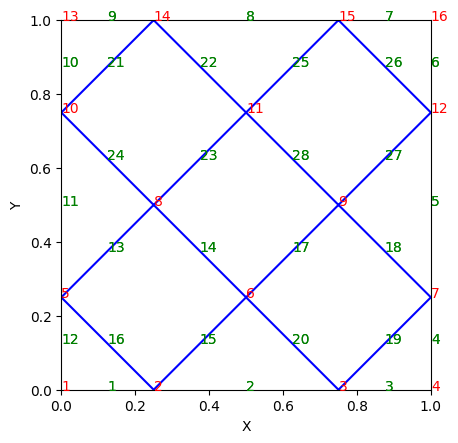

In [ ]:
a,b,c=rect_partition(2)

In [ ]:
def partition_rect(n):
    p = np.array([[0, 0.25, 0.5, 0.25],
                [0.25, 0.5, 0.25, 0]])
    s = np.array([[1, 2, 3, 1],
                  [2, 3, 4, 4],
                  [1, 1, 1, 1],
                  [-1, -2, -3, -4]])
    t = np.array([[1], [2], [3], [4], [1], [2], [3], [4]])
    H = 4
    NP = 4
    NS = 4
    NT = 1
    for k in range(n):
        P = np.zeros((2, NP))
        S = np.zeros((2, NS))
        T = np.zeros((2, NT))
        P=p
        S=s.astype(int)
        T=t.astype(int)
        p1 = np.zeros((2, NS))
        for i in range(NS):
            p1[:, i] = [(P[0, S[0, i]-1] + P[0, S[1, i]-1])/2, (P[1, S[0, i]-1] + P[1, S[1, i]-1])/2]
        p2 = np.zeros((2, NT))
        for i in range(NT):
            p2[:,i] = [(P[0,T[0,i]-1]+P[0,T[2,i]-1])/2, (P[1,T[0,i]-1]+P[1,T[2,i]-1])/2]
        p = np.concatenate((p, p1, p2), axis=1)
        s1 = np.zeros((4, 2*NS))
        for i in range(NS):
            s1[:,2*i] = np.array([S[0,i], NP+i+1, S[2,i], S[3,i]])
            s1[:,2*i+1] = np.array([NP+i+1, S[1,i], S[2,i], S[3,i]])
        s2 = np.zeros((4, 4*NT))
        for i in range(NT):
            s2[0:4, 4*i] = [NP+T[4,i], NP+NS+i+1, i+1, i+1]
            s2[0:4, 4*i+1] = [NP+T[5,i], NP+NS+i+1, i+1, i+1]
            s2[0:4, 4*i+2] = [NP+T[6,i], NP+NS+i+1, i+1, i+1]
            s2[0:4, 4*i+3] = [NP+T[7,i], NP+NS+i+1, i+1, i+1]
        s = np.concatenate((s1, s2), axis=1)
        N = 2*NS + 4*NT
        for i in range(N):
            temp = 0
            if s[1, i] < s[0, i]:
                temp = s[1, i]
                s[1, i] = s[0, i]
                s[0, i] = temp
        t1 = np.zeros((8, 4*NT))
        for i in range(NT):
            t1[0:4,4*(i+1)-4] = [T[0,i],NP+T[4,i],NP+NS+i+1,NP+T[7,i]]
            t1[0:4,4*(i+1)-3] = [NP+T[4,i],T[1,i],NP+T[5,i],NP+NS+i+1]
            t1[0:4,4*(i+1)-2] = [NP+NS+i+1,NP+T[5,i],T[2,i],NP+T[6,i]]
            t1[0:4,4*(i+1)-1] = [NP+T[7,i],NP+NS+i+1,NP+T[6,i],T[3,i]]
            t1[5,4*(i+1)-4]=2*NS+4*(i+1)-3
            t1[7,4*(i+1)-3]=2*NS+4*(i+1)-3
            t1[4,4*(i+1)-2]=2*NS+4*(i+1)-2
            t1[6,4*(i+1)-3]=2*NS+4*(i+1)-2
            t1[6,4*(i+1)-3]=2*NS+4*(i+1)-2
            t1[7,4*(i+1)-2]=2*NS+4*(i+1)-1
            t1[5,4*(i+1)-1]=2*NS+4*(i+1)-1
            t1[6,4*(i+1)-4]=2*NS+4*(i+1)
            t1[4,4*(i+1)-1]=2*NS+4*(i+1)
            
            if T[0, i] < T[1, i]:
                t1[4, 4*(i+1)-4] = 2*T[4, i]-1
                t1[4, 4*(i+1)-3] = 2*T[4, i]
            else:
                t1[4, 4*(i+1)-4] = 2*T[4, i]
                t1[4, 4*(i+1)-3]= 2*T[4, i]-1
                
            if T[1, i] < T[2, i]:
                t1[5, 4*(i+1)-3] = 2*T[5, i]-1
                t1[5, 4*(i+1)-2] = 2*T[5, i]
            else:
                t1[5, 4*(i+1)-3] = 2*T[5, i]
                t1[5, 4*(i+1)-2] = 2*T[5, i]-1
            
            if T[2, i] < T[3, i]:
                t1[6, 4*(i+1)-2] = 2*T[6, i]-1
                t1[6, 4*(i+1)-1] = 2*T[6, i]
            else:
                t1[6, 4*(i+1)-2] = 2*T[6, i]
                t1[6, 4*(i+1)-1] = 2*T[6, i]-1
                
            if T[0, i] < T[3, i]:
                t1[7, 4*(i+1)-4] = 2*T[7, i]-1
                t1[7, 4*(i+1)-1] = 2*T[7, i]
            else:
                t1[7, 4*(i+1)-4] = 2*T[7, i]
                t1[7, 4*(i+1)-1] = 2*T[7, i]-1
        t = t1
        a, nt = t.shape[0], t.shape[1]
        a, ns = s.shape[0], s.shape[1]
        tr = np.ones(ns)
        for i in range(nt):
            for j in range(4, 8):
                if t[j,i]-1 <= (k+2)*H:
                    s[2,int(t[j,i])-1] = i+1
                else:
                    if tr[int(t[j,i])-1] > 0:
                        s[2,int(t[j,i])-1] = i+1
                        tr[int(t[j,i])-1] = -1
                    else:
                        s[3,int(t[j,i])-1] = i+1
        NP = np.size(p[0,:])
        NS = np.size(s[0,:])
        NT = np.size(t[0,:])
    s=s.astype(int)
    t=t.astype(int)
    h = 1/2**n
    plt.figure()
    for i in range(p.shape[1]):
        temp = str(i+1)
        plt.text(p[0,i]+0.1*h, p[1,i]-0.1*h, temp, color='blue')
        plt.plot(p[0,i], p[1,i], 'r*')
    for i in range(s.shape[1]):
        temp = str(i+1)
        plt.text(sum(p[0,s[0:2,i]-1])/2+.002, sum(p[1,s[0:2,i]-1])/2-.005, temp, color='green')
        plt.plot(p[0,s[0:2,i]-1],p[1,s[0:2,i]-1])
    for i in range(t.shape[1]):
        temp = str(i+1)
        plt.text(sum(p[0,t[0:4,i]-1])/4, sum(p[1,t[0:4,i]-1])/4, temp, color='red')
    plt.xlim(0, 0.5)
    plt.ylim(0, 0.5)
    plt.show()
    return p,s,t

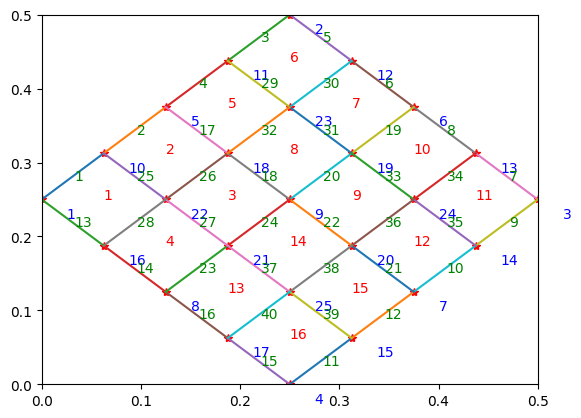

In [ ]:
a,b,c=partition_rect(2)

In [ ]:
def u01(x, y):
    global d1

    if d1 == 1:
        z = np.vstack((np.ones_like(x), x, y)).T
    elif d1 == 2:
        z = np.vstack((np.ones_like(x), x, y, x**2, x*y, y**2)).T
    elif d1 == 3:
        z = np.vstack((np.ones_like(x), x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3)).T
    elif d1 == 4:
        z = np.vstack((np.ones_like(x), x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3, x**4, x**3*y, x**2*y**2, x*y**3, y**4)).T
    elif d1 == 5:
        z = np.vstack((np.ones_like(x), x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3, x**4, x**3*y, x**2*y**2, x*y**3, y**4, x**5, x**4*y, x**3*y**2, x**2*y**3, x*y**4, y**5)).T
    elif d1 == 6:
        z = np.vstack((np.ones_like(x), x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3, x**4, x**3*y, x**2*y**2, x*y**3, y**4, x**5, x**4*y, x**3*y**2, x**2*y**3, x*y**4, y**5, x**6, x**5*y, x**4*y**2, x**3*y**3, x**2*y**4, x*y**5, y**6)).T
    else:
        raise ValueError(f"Invalid value of d1: {d1}")
    
    return z

In [ ]:
def ub(t):
    global d2
    if d2 == 0:
        z = np.ones(1).reshape(-1,1)
        
    elif d2 == 1:
        z = np.column_stack([1-t, t])
        
    elif d2 == 2:
        z = np.column_stack([(1-t)**2, t*(1-t), t**2])
        
    elif d2 == 3:
        z = np.column_stack([t**3, t**2*(1-t), t*(1-t)**2, (1-t)**3])
        
    elif d2 == 4:
        z = np.column_stack([t**4, t**3*(1-t), t**2*(1-t)**2, t*(1-t)**3, (1-t)**4])
        
    elif d2 == 5:
        z = np.column_stack([t**5, t**4*(1-t), t**3*(1-t)**2, t**2*(1-t)**3, t*(1-t)**4, (1-t)**5])
    
    elif d2 == 6:
        z = np.column_stack([t**6, t**5*(1-t), t**4*(1-t)**2, t**3*(1-t)**3, t**2*(1-t)**4, t*(1-t)**5, (1-t)**6])
        
    return z

In [ ]:
import numpy as np

def ul(t):
    global d3
    if d3 == 0:
        return np.ones(1).reshape(-1,1)
    elif d3 == 1:
        return np.vstack((t, 1 - t)).T
    elif d3 == 2:
        return np.vstack((t, t * (1 - t), 1 - t)).T
    elif d3 == 3:
        return np.vstack((t ** 3, t ** 2 * (1 - t), t * (1 - t) ** 2, (1 - t) ** 3)).T
    elif d3 == 4:
        return np.vstack((t ** 4, t ** 3 * (1 - t), t ** 2 * (1 - t) ** 2, t * (1 - t) ** 3, (1 - t) ** 4)).T
    elif d3 == 5:
        return np.vstack((t ** 5, t ** 4 * (1 - t), t ** 3 * (1 - t) ** 2, t ** 2 * (1 - t) ** 3, t * (1 - t) ** 4, (1 - t) ** 5)).T
    elif d3 == 6:
        return np.vstack((t ** 6, t ** 5 * (1 - t), t ** 4 * (1 - t) ** 2, t ** 3 * (1 - t) ** 3, t ** 2 * (1 - t) ** 4, t * (1 - t) ** 5, (1 - t) ** 6)).T
    else:
        raise ValueError("Invalid value of d3")
    return z

In [ ]:
def nablaw_basis(x, y):
    global d3
    if d3 == 0:
        z = np.array([[1, 0], [0, 1]])
    elif d3 == 1:
        z = np.array([[1, x, y, 0, 0, 0],
                      [0, 0, 0, 1, x, y]])
    elif d3 == 2:
        z = np.array([[1, x, y, x**2, x*y, y**2, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 1, x, y, x**2, x*y, y**2]])
    elif d3 == 3:
        z = np.array([[1, x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3]])
    elif d3 == 4:
        z = np.array([[1, x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3, x**4, x**3*y, x**2*y**2, x*y**3, y**4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3, x**4, x**3*y, x**2*y**2, x*y**3, y**4]])
    elif d3 == 5:
        z = np.array([[1, x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3, x**4, x**3*y, x**2*y**2, x*y**3, y**4, 
                       x**5, x**4*y, x**3*y**2, x**2*y**3, x*y**4, y**5], 
                      [0]*21, 
                      [0]*21])
    elif d3 == 6:
        z = np.array([[1, x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3, x**4, x**3*y, x**2*y**2, x*y**3, y**4, 
                       x**5, x**4*y, x**3*y**2, x**2*y**3, x*y**4, y**5, x**6, x**5*y, x**4*y**2, x**3*y**3, 
                       x**2*y**4, x*y**5, y**6], 
                      [0]*28, 
                      [0]*28])
    else:
        raise ValueError("d3 must be either 0, 5, or 6.")
        
    return z

In [ ]:
def mass_ref():
    x, y, t = sp.symbols('x y t')

    v0 =sp.Matrix(u01(x, y))
    vb = sp.Matrix(ub(t))
    q = nablaw_basis(x, y)

    v0v0 = sp.integrate(sp.integrate(sp.Matrix(v0.T @ v0), (x, 0, 1)), (y, 0, 1))
    vbvb = sp.integrate(sp.Matrix(vb.T @ vb), (t, 0, 1))
    v0v0=np.array(v0v0)
    vbvb=np.array(vbvb)
    vbvb=np.float64(vbvb)
    v0v0=np.float64(v0v0)
    q=sp.Matrix(q)

    qqidx = np.zeros((12, 12, 4))
    for i in range(2):
        for j in range(2):
            idx = 2 * i + j
            qqidx[:,:,idx] = sp.integrate(sp.integrate(
                sp.Matrix(q[i,:].T@ q[j,:]), (x, 0, 1)),(y, 0, 1))

    return v0v0, vbvb, qqidx

In [ ]:
def nablaw_basis(x, y):
    global d3
    
    if d3 == 0:
        return np.array([[1, 0], [0, 1]])
    elif d3 == 1:
        return np.array([[1, x, y, 0, 0, 0],
                      [0, 0, 0, 1, x, y]])
    elif d3 == 2:
        return np.array([[1, x, y, x**2, x*y, y**2, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 1, x, y, x**2, x*y, y**2]])
    elif d3 == 3:
        return np.array([[1, x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3]])
    elif d3 == 4:
        return np.array([[1, x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3,
                       x**4, x**3*y, x**2*y**2, x*y**3, y**4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3,
                       x**4, x**3*y, x**2*y**2, x*y**3, y**4]])
    elif d3 == 5:
        return np.array([np.array([1, x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3, x**4, x**3*y, x**2*y**2, x*y**3, y**4, x**5, x**4*y, x**3*y**2, x**2*y**3, x*y**4, y**5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
                          np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3, x**4, x**3*y, x**2*y**2, x*y**3, y**4, x**5, x**4*y, x**3*y**2, x**2*y**3, x*y**4, y**5])])


In [ ]:
import scipy.sparse as sp1
def nablaw_ref():

    x, y, t = sp.symbols('x y t', real=True)

    v0 = u01(x, y)
    vb = ub(t)
    q = nablaw_basis(x, y)
    vo=sp.Matrix(v0)
    n1=np.array([0,-1]).reshape(-1,1)
    n2=np.array([1,0]).reshape(-1,1)
    n3=np.array([0,1]).reshape(-1,1)
    n4=np.array([-1,0]).reshape(-1,1)
    l1 = 1
    q=sp.Matrix(q)
    divq = sp.diff(q[0, :], x) + sp.diff(q[1, :], y)
    qn1 = (n1.T@q).subs([(x, t), (y, 0)])
    qn2 = (n2.T@q).subs([(x, 1), (y, t)])
    qn3 = (n3.T@q).subs([(x, 1-t), (y, 1)])
    qn4 = (n4.T@q).subs([(x, 0), (y, 1-t)])

    qq = sp.integrate(sp.integrate(q.T @ q, (x, 0, 1)), (y, 0, 1))
    divqv0 = -sp.integrate(sp.integrate(divq.T @ v0, (x, 0, 1)), (y, 0, 1))
    qn1vb = l1 * sp.integrate(qn1.T @ vb, (t, 0, 1))
    qn2vb = l1 * sp.integrate(qn2.T @ vb, (t, 0, 1))
    qn3vb = l1 * sp.integrate(qn3.T @ vb, (t, 0, 1))
    qn4vb = l1 * sp.integrate(qn4.T @ vb, (t, 0, 1))

    ggr=np.hstack((np.array((sp.simplify(divqv0)).tolist()),np.array((sp.simplify(qn1vb)).tolist()),np.array((sp.simplify(qn2vb)).tolist()),np.array((sp.simplify(qn3vb)).tolist()),np.array((sp.simplify(qn4vb)).tolist())))
    gg=sp.Matrix(ggr)
    z=sp.Matrix(sp.simplify(qq).inv()@gg)
    return z

In [ ]:
def stable_ref2():
    x, y, s = sp.symbols('x y s', real=True)
    v0 = sp.Matrix(u01(x, y))
    vb = sp.Matrix(ub(s))
    vl = sp.Matrix(ul(s))
    vb=np.array(vb)
    vl=np.array(vl)


    v01 = v0.subs([(x, s), (y, 0)])
    v02 = v0.subs([(x, 1), (y, s)])
    v03 = v0.subs([(x, 1-s), (y, 1)])
    v04 = v0.subs([(x, 0), (y, 1-s)])

    vlvl = sp.integrate(sp.Matrix(vl.T @ vl), (s, 0, 1))

    Qbv01 = vlvl.inv() @ sp.integrate(vl.T @ v01, (s, 0, 1))
    Qbv02 = vlvl.inv() @ sp.integrate(vl.T @ v02, (s, 0, 1))
    Qbv03 = vlvl.inv() @ sp.integrate(vl.T @ v03, (s, 0, 1))
    Qbv04 = vlvl.inv() @ sp.integrate(vl.T @ v04, (s, 0, 1))
    zr = np.zeros((vl.shape[1], vb.shape[1])).astype(int)
    vbvl = vlvl.inv() @ sp.integrate(sp.Matrix(vl.T @ vb), (s, 0, 1))
    v1 = np.hstack((Qbv01,-vbvl,zr,zr,zr))
    v2 = np.hstack((Qbv02,zr,-vbvl,zr,zr))
    v3 = np.hstack((Qbv03,zr,zr,-vbvl,zr))
    v4 = np.hstack((Qbv04,zr,zr,zr,-vbvl))
    
    z = np.zeros((v1.shape[1], v1.shape[1], 4))
    z[:, :, 0] = (v1.T @ vlvl @ v1)
    z[:, :, 1] = (v2.T @ vlvl @ v2)
    z[:, :, 2] = (v3.T @ vlvl @ v3)
    z[:, :, 3] = (v4.T @ vlvl @ v4)
    return z


In [ ]:

def stable_ref1():
    x, y, t = symbols('x y t', real=True)

    v0 = u01(x, y)
    vb = ub(t)

    v01 = sp.subs(v0, [(x, 1-t), (y, t)])
    v02 = sp.subs(v0, [(x, 0), (y, 1-t)])
    v03 = sp.subs(v0, [(x, t), (y, 0)])

    vbvb = integrate(vb.T * vb, (t, 0, 1))

    Qbv01 = vbvb.inv() * integrate(vb.T * v01, (t, 0, 1))
    Qbv02 = vbvb.inv() * integrate(vb.T * v02, (t, 0, 1))
    Qbv03 = vbvb.inv() * integrate(vb.T * v03, (t, 0, 1))

    zr = zeros((len(vb), len(vb)))
    v1 = np.hstack([Qbv01, -eye(len(vb)), zr, zr])
    v2 = np.hstack([Qbv02, zr, -eye(len(vb)), zr])
    v3 = np.hstack([Qbv03, zr, zr, -eye(len(vb))])

    z = np.zeros((v1.shape[1], v1.shape[1], 3))
    z[:, :, 0] = v1.T @ vbvb @ v1
    z[:, :, 1] = v2.T @ vbvb @ v2
    z[:, :, 2] = v3.T @ vbvb @ v3

    return z.astype(float)

In [ ]:
n0 = nb = S_pre = A00_pre = None
nabla_w_pre = DwDw_pre = draw = solu = rhs = None
alpha = beta = gamma = para = None
gs1_pt = gs1_wt = None
gs1_num = Q_0 = Q_b = None
d1 = d2 = d3 = None


def pre_setting():
    global n0, nb, S_pre, A00_pre
    global nabla_w_pre, DwDw_pre, draw, solu, rhs
    global alpha, beta, gamma, para
    global gs1_pt, gs1_wt, gs1_num, Q_0, Q_b
    global d1, d2, d3

    np.set_printoptions(precision=15)

    draw = 1
    alpha = 1
    beta=np.array([[0],[0]]).T
    gamma = 0
    para = 1

    n0=u01(0,0).shape[1]
    nb=ub(0).shape[1]

    A00_pre, Q_b, DwDw_pre = mass_ref()
    Q_0 = A00_pre

    nabla_w_pre = nablaw_ref()
    nabla_w_pre=np.float64(np.array(nabla_w_pre))

    if db > dnw:
        S_pre = stable_ref1()
    else:
        S_pre = stable_ref2()
    gs1_wt = [0.118463442528095, 0.239314335249683, 0.284444444444445,
              0.239314335249683, 0.118463442528095]
    gs1_pt = [0.046910077030668, 0.230765344947158, 0.5,
              0.769234655052842, 0.953089922969332]
    gs1_num = 5

In [ ]:
def WG_partition(n):
    global p, s, t
    global NT, NE
    global n0, nb
    global dou0, doub, dof
    
    # p, s, t = rect_partition(n)
    p,s,t=partition_rect(n)
    p=np.array(p)
    s=np.array(s)
    t=np.array(t)
    NT = t.shape[1]
    NE = s.shape[1]
    dou0 = n0*NT
    doub = nb*NE
    dof = dou0+doub


In [ ]:
def loc_u0(i):
    global n0 
    loc_0 = np.arange(0, n0)+(n0)*(i)
    return loc_0

In [ ]:
def loc_ub(i):
    global nb, dou0, t
    loc_b=nb*np.ones((nb,1))*t[4:8,i].T+np.arange(nb).reshape((-1, 1)) * np.ones((1, 4))-nb+dou0
    return loc_b.flatten('F').astype(int)

In [ ]:
def stiffness_matrix1():
    global p, t, NT, n0, nb, dof, S_pre, A00_pre, nabla_w_pre, DwDw_pre, A, h, gamma, rect_area
    
    h = 0
    dof_loc = n0 + 4*nb
    ia = np.zeros((dof_loc*NT, dof_loc), dtype=int)
    ja = np.zeros((dof_loc*NT, dof_loc), dtype=int)
    va = np.zeros((dof_loc*NT, dof_loc))
    rect_area = np.zeros((NT,1))
    t=t.astype(int)
    for i in range(NT):
        P = p[0:2, t[0:4, i]-1]
        E1 = np.zeros((2, 4))
        E1[:, [0, 1, 2, 3]] = P[:, [1,2, 3, 0]] - P[:, [0,1, 2, 3]]
        L1 = np.sqrt(np.sum(E1**2, axis=0))
        E=np.zeros((2,3))
        E[:,[0,1,2]]=P[:, [3, 0, 1]] - P[:, [1, 3, 0]]
        rect_area[i] =L1[0]*L1[1]
        h_T = L1[0]
        K = L1[0]*L1[1]
        h = max([h_T, h])
        D = np.linalg.inv(np.array([E[:, 2], -E[:, 1]]).T)
        nabla_w_pre=sp.Matrix(nabla_w_pre)
        nabla_w = nabla_w_pre.T
        T = D.T @ D
        DwDw = (T[0, 0] * DwDw_pre[:, :, 0] + T[0, 1] * DwDw_pre[:, :, 1] +
                T[1, 0] * DwDw_pre[:, :, 2] + T[1, 1] * DwDw_pre[:, :, 3]) * K
        A00 = A00_pre * K
        Abb = nabla_w @ DwDw @ nabla_w.T
        S_loc = np.zeros((n0+(4*nb)))
        for j in range(4):
            S_loc = S_loc + S_pre[:, :, j] * L1[j] / h_T
        
        A_loc=Abb
        A_loc[0:3,0:3]=Abb[0:3,0:3]+A00
        # A_loc = A_loc + S_loc
        loc_0 = loc_u0(i)
        loc_b = loc_ub(i)
        loc = np.concatenate((loc_0, loc_b))
        ptorder = [0, 1, 2, 3, 0]
        for j in range(1,5):
            if t[ptorder[j], i] > t[ptorder[j-1], i]:
                loc[n0+nb*j-nb:n0+nb*j]=loc[n0+nb*j-1:n0+nb*j-nb-1:-1]
        x, y = np.meshgrid(loc, loc)
        ia[dof_loc * i : dof_loc * (i + 1), :] = x
        ja[dof_loc * i:dof_loc * (i+1), :] = y
        va[dof_loc * i:dof_loc * (i+1), :] = A_loc

    A = csr_matrix((va.ravel(), (ia.ravel(),ja.ravel())),shape=(dof,dof))

In [ ]:
def stiffnessmat_C():
    global p, t, n0, dof, Q_0, NT, C,Area
    
    ia = np.zeros((n0*NT, n0))
    ja = np.zeros((n0*NT, n0))
    va = np.zeros((n0*NT, n0))
    for i in range(NT):
        Area = 1/NT
        loc = np.arange(n0*(i), n0*(i+1))
        mesh = np.meshgrid(loc, loc, indexing='ij')
        x, y = mesh[0], mesh[1]
        ia[n0*i:n0*(i+1), :] = x
        ja[n0*i:n0*(i+1), :] = y
        va[n0*i:n0*(i+1), :] = Q_0 * Area
    
    C = csc_matrix((va.ravel(), (ia.ravel(), ja.ravel())), shape=(dof, dof))

In [ ]:

def f(x, y):
    # z = 2*np.pi*np.pi*np.sin(np.pi*x)*np.sin(np.pi*y)
    z=2*np.pi**2*np.cos(np.pi*(x + y))*math.exp(x + y) - np.cos(np.pi*(x + y))*math.exp(x + y) + 4*np.pi*math.exp(x + y)*np.sin(np.pi*(x + y))
    return z

In [ ]:
def u_real(x, y):
    # z = np.sin(np.pi * x) * np.sin(np.pi * y)
    z = np.sin(x+y) * np.cos(np.pi * (x+y))
    return z

In [ ]:
def u0(P,x,y):
    global d1

    x1 = P[0,0]
    x2 = P[0,1]
    y1 = P[1,0]
    y2 = P[1,3]

    L = np.zeros(4)
    L[1] = (x-x1)/(x2-x1)
    L[2] = (y-y1)/(y2-y1)

    if d1 == 1:
        z = np.array([1, L[1], L[2]])
    elif d1 == 2:
        z = np.array([1, L[1], L[2], L[1]**2, L[1]*L[2], L[2]**2])
    elif d1 == 3:
        z = np.array([1, L[1], L[2], L[1]**2, L[1]*L[2], L[2]**2, L[1]**3, L[1]**2*L[2], L[2]**2*L[1], L[2]**3])
    elif d1 == 4:
        z = np.array([1, L[1], L[2], L[1]**2, L[1]*L[2], L[2]**2, L[1]**3, L[1]**2*L[2], L[2]**2*L[1], L[2]**3, L[1]**4, L[1]**3*L[2], L[1]**2*L[2]**2, L[1]*L[2]**3, L[2]**4])
  
    return z


In [ ]:
def pdt_2d(fun1, fun2, x, y):
    return fun1(x, y) * fun2(x, y)

In [ ]:

def gint_2d_rect(fun,P):
    x1, x2 = P[0,0], P[0,1]
    y1, y2 = P[1,0], P[1,3]

    weight = np.array([0.1142208673789570,0.1134763461089651,0.1134763461089651,
                       0.1112524883568452,0.1112524883568452,0.1075782857885332,
                       0.1075782857885332,0.1025016378177458,0.1025016378177458,
                       0.0960887273700285,0.0960887273700285,0.0884231585437569,
                       0.0884231585437569,0.0796048677730578,0.0796048677730578,
                       0.0697488237662456,0.0697488237662456,0.0589835368598336,
                       0.0589835368598336,0.0474494125206151, 0.0474494125206151,
                       0.0352970537574197,0.0352970537574197,0.0226862315961806,
                       0.0226862315961806,0.0097989960512944,0.0097989960512944])

    location = np.array([0.0000000000000000,-0.1139725856095300,0.1139725856095300,
                         -0.2264593654395368,0.2264593654395368,-0.3359939036385089,
                         0.3359939036385089, -0.4411482517500269,0.4411482517500269,
                         -0.5405515645794569,0.5405515645794569,-0.6329079719464952,
                         0.6329079719464952,-0.7170134737394237,0.7170134737394237,
                         -0.7917716390705082,0.7917716390705082,-0.8562079080182945,
                         0.8562079080182945,-0.9094823206774911,0.9094823206774911,
                         -0.9509005578147051,0.9509005578147051,-0.9799234759615012,
                         0.9799234759615012,-0.9961792628889886,0.9961792628889886])

    location = (location+1)/2
    locx = x1 + location*(x2-x1)
    locy = y1 + location*(y2-y1)
    K = abs((y2-y1)*(x2-x1))

    z = 0
    for i in range(27):
      for j in range(27):
          z = z + K/4 * weight[i] * weight[j] * fun(locx[i], locy[j])
    return z


In [ ]:
def inpdt_2d_rect(fun1, fun2,P):
  z = gint_2d_rect(lambda x, y: pdt_2d(fun1, fun2, x, y), P)
  return z

In [ ]:
def right_side():
    global NT, dof, t, p, F, rhs
    
    F = np.zeros((dof,1))
    
    for i in range(NT):
        P = p[0:2, t[0:4,i]-1]
        
        loc_0 = loc_u0(i)
        F[loc_0] = inpdt_2d_rect(f, lambda x, y: u0(P, x, y), P).reshape(-1,1)

In [ ]:
def ul3(t):
    global d2
    
    if d2 == 0:
        z = np.ones(1).reshape(-1,1)
    elif d2 == 1:
        z = np.vstack([t, 1-t]).T
    elif d2 == 2:
        z = np.vstack([t**2, t*(1-t), (1-t)**2]).T
    elif d2 == 3:
        z = np.vstack([t**3, t**2*(1-t), t*(1-t)**2, (1-t)**3]).T
    elif d2 == 4:
        z = np.vstack([t**4, t**3*(1-t), t**2*(1-t)**2, t*(1-t)**3, (1-t)**4]).T
    elif d2 == 5:
        z = np.vstack([t**5, t**4*(1-t), t**3*(1-t)**2, t**2*(1-t)**3, t*(1-t)**4, (1-t)**5]).T
    elif d2 == 6:
        z = np.vstack([t**6, t**5*(1-t), t**4*(1-t)**2, t**3*(1-t)**3, t**2*(1-t)**4, t*(1-t)**5, (1-t)**6]).T
    
    return z


In [ ]:
def pdt_1d(fun1, fun2, t):
    return fun1(t) * fun2(t)

In [ ]:
def gint_1d(fun, a, b):
    weight = [0.236926885056189, 0.478628670499366, 0.568888888888889,
              0.478628670499366, 0.236926885056189]
    location = [0.046910077030668, 0.230765344947158, 0.5,
                0.769234655052842, 0.953089922969332]
    y = 0
    for i in range(5):
        y += weight[i] * fun(a + location[i] * (b - a)) * (b - a) / 2
    return y

In [ ]:
def inpdt_1d(fun1, fun2, a,b):
  z=gint_1d(lambda t: fun1(t) * fun2(t), a, b)
  return z

In [ ]:
def Qb(f, P):
    global Q_b

    F = inpdt_1d(lambda t: f((1-t)*P[0,0] + t*P[0,1], (1-t)*P[1,0] + t*P[1,1]), ul3, 0,1)
    z = np.linalg.solve(Q_b, F.T)
    return z

In [ ]:
def Dirichlet_boundary():
    global s, p, NE, dou0, dof, nb, A, F, solu
    s=s.astype(int)
    for i in range(NE):
        if s[3,i] <= 0:
            P = p[0:2, s[0:2,i]-1]
            loc_b = np.arange(nb) + nb*(i) + dou0
            F[loc_b] = Qb(u_real, P)
            A[loc_b,:] = np.zeros((nb, dof))
            A[loc_b[:,None], loc_b] = np.eye(nb)

In [ ]:
def solve_WG():
    global A, F, dof, uh, p,t,NT,n0
    uh = np.linalg.solve(A.toarray(), F)

In [ ]:
def Q0(f, P):
    global Q_0, Area
    K = Area
    F = inpdt_2d_rect(f, lambda x, y: u0(P, x, y), P) / K
    return np.linalg.solve(Q_0, F)

In [ ]:
def Qh(fun):
    global dof, dou0,  nb 
    global p, s, t, NT, NE
    Qhu = np.zeros(dof)
    for i in range(NT):
        P =p[0:2,t[0:4,i]-1]
        loc_0=loc_u0(i)
        Qhu[loc_0]=Q0(fun,P)
    for i in range(NE):
        P = p[0:2, s[0:2, i]-1]
        loc_b = np.arange(nb) + nb*(i-1) + dou0
        Qhu[loc_b] = Qb(fun, P).reshape(1,-1)
    return Qhu

In [ ]:
def error_est():
    global dou0, doub, uh, A, C, solu, draw, err,Qhum,K8

    Qhu = Qh(lambda x, y: u_real(x, y)).reshape(-1,1)
    eh = Qhu - uh
    loc_u = np.arange(0, dou0 + doub)
    err_trb = eh[loc_u].T @ A[loc_u][:, loc_u] @ eh[loc_u]
    err_trb = np.sqrt(err_trb)
    err_L2 = np.sqrt(eh.T @ C @ eh)
    err_trb = (err_L2)**(K8/(K8+1))
    err = [err_trb, err_L2]

In [ ]:
def main():
    global d1, d2, d3, err, h, K8,uh, Area, dof,nb,t,F
    n11 = 1
    n1 =[1, 2]
    H = np.zeros((1, len(n1)))
    H1_error = np.zeros((1, len(n1)))
    L2_error = np.zeros((1, len(n1)))
    L2_Order = np.zeros((1, len(n1)))
    H1_Order = np.zeros((1, len(n1)))

    for k in range(1,2):    
        d0 = k
        db = k+1
        dnw = k+1
        K8 =k;
        for l in range(1,3):
            n=2**l
            d1 = d0
            d2 = db
            d3 = dnw
            pre_setting()
            WG_partition(n)
            stiffness_matrix1()
            stiffnessmat_C()
            right_side()
            Dirichlet_boundary()
            solve_WG()
            error_est()
            H[0,l-1]=h
            H1_error[0,l-1] = err[0]
            L2_error[0,l-1] = err[1]
        
        for j in range(l):
            L2_Order[0,j] = math.log(L2_error[0,j]) / math.log(H[0,j])
        for j in range(l):
            H1_Order[0,j] = math.log(H1_error[0,j]) / math.log(H[0,j])
        L2_error = L2_error.T
        L2_EOC = L2_Order.T

        H1_error = H1_error.T
        H1_EOC = H1_Order.T
        L2_EOC[0]=0
        H1_EOC[0]=0
        label=H.T
        label[0]=1
        label[1]=2

        print('\n Error and Order of accuracy\n\n')
        print('Mesh Level\tL2_Error\tL2_EOC\t\tH1_Error\tH1_EOC\n')
        for i in range(2):
            print('{:>8f}\t{:>8f}\t{:>8f}\t{:>8f}\t{:>8f}'.format(*label[i], *L2_error[i], *L2_EOC[i], *H1_error[i], *H1_EOC[i]))
        


 Error and Order of accuracy


Mesh Level	L2_Error	L2_EOC		H1_Error	H1_EOC

1.000000	0.208107	0.000000	0.456188	0.000000
2.000000	0.200333	0.421733	0.447585	0.210866
